In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, LinearRegression, RidgeCV
from sklearn.model_selection import cross_val_predict, KFold, train_test_split
%load_ext autoreload
%autoreload 2
import phate, ephate, random, scipy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.svm import LinearSVC, SVC
from demo_data_helpers import load_simulated_data_manifold_example
from sklearn import datasets
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

%matplotlib inline

# Set seed for reproducibility
SEED=4
random.seed(4)
np.random.seed(4) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Toy datasets - when/why do nonlinear datasets result in better embeddings?
We're going to start with three publicly available datasets that should provide some visual support for using nonlinear methods to embed certain kinds of data. We're going to look at one linear dimensionality reduction method --- PCA --- and compare it with two nonlinear manifold learning methods -- T-SNE and PHATE. 

## Dataset 1: Iris
The iris dataset is one of the most classic datasets. It has 150 samples and 4 features, and all of the samples belong to one of three classes. It's a relatively small, low-dimensional, and clean dataset, and its embeddings create linearly separable categories. 

/gpfs/milgram/project/casey/elb77/conda_envs/wxyz/lib/python3.11/site-packages/graphtools/graphs.py:283: RuntimeWarning: Detected zero distance between samples 101 and 142. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(


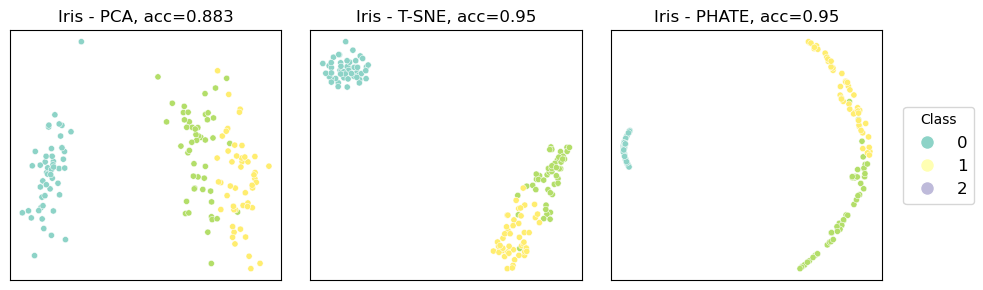

In [338]:
iris_data, iris_labels = datasets.load_iris(return_X_y=True)
# normalize the data features across samples
iris_data = scipy.stats.zscore(iris_data, axis=1)
# embed with PCA, T-SNE, and PHATE -- using each method's default parameters 
iris_pca = PCA(n_components=2).fit_transform(iris_data)
iris_tsne = TSNE(n_components=2,verbose=0).fit_transform(iris_data)
iris_phate = phate.PHATE(n_components=2,verbose=0).fit_transform(iris_data)

# run a classifier over these embeddings
accuracies = []
for d in [iris_pca, iris_tsne, iris_phate]:
    X_train, X_test, y_train, y_test = train_test_split(d, iris_labels, test_size=0.4, random_state=0)
    mod = LinearSVC().fit(X_train,y_train)
    acc = mod.score(X_test,y_test)
    accuracies.append(acc)

fig = plt.figure(figsize=(10, 3))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.2])  # 3 matrices + 1 narrow colorbar

uniq_labels = np.unique(iris_labels)
palette=sns.color_palette('Set3',len(uniq_labels))
color_dict = {group: color for group, color in zip(uniq_labels, palette)}

# Create axes for each matrix and colorbar
axes = [plt.subplot(gs[i]) for i in range(4)]

g=sns.scatterplot(x=iris_pca[:,0], y=iris_pca[:,1], c=iris_labels,  ax=axes[0],s=20, cmap='Set3',legend=False)
g.set(xticks=[],yticks=[],title=f'Iris - PCA, acc={np.round(accuracies[0],3)}')

g=sns.scatterplot(x=iris_tsne[:,0], y=iris_tsne[:,1], c=iris_labels,  ax=axes[1], s=20, cmap='Set3',legend=False)
g.set(xticks=[],yticks=[],title=f'Iris - T-SNE, acc={np.round(accuracies[1],3)}')

g=sns.scatterplot(x=iris_phate[:,0], y=iris_phate[:,1], c=iris_labels, ax=axes[2],s=20, cmap='Set3',legend=False)
g.set(xticks=[],yticks=[],title=f'Iris - PHATE, acc={np.round(accuracies[2],3)}')

axes[3].axis('off')


# Create custom legend handles
legend_handles = []
for group, color in color_dict.items():
    handle = Line2D(
        [0], [0], 
        marker='o', 
        color='w',
        markerfacecolor=color, 
        markersize=10, 
        label=group
    )
    legend_handles.append(handle)

# Add the legend to the separate axis with adjusted parameters for many groups
legend = axes[3].legend(
    handles=legend_handles, 
    loc='center', 
    fontsize=10 
    frameon=True, 
    title='Class',
    ncol=1 
)


fig.tight_layout()

What does this show us? well, it appears that these data are quite separable in both linear and nonlinear dimensions -- visually, you can see that the PCs and the nonlinear dimensions all push apart flowers from different groups, and that the green/yellow classes are closer than the purple class, showing that the geometry is preserved across embedding methods. Classification accuracy for all three embeddings is pretty high, too, well above the 33% chance. Though we get better accuracy with the nonlinear embeddings, this is not an overwhelming difference. In all, for this low-dimensional and clean dataset, embedding in nonlinear dimensions does not result in overwhelming improvements!

## Dataset 2: digits
What about a higher-dimensional, noiser dataset? Next, let's consider the digits dataset. This dataset contains ~1800 samples and 64 features. The 64 features are a vectorized version of 8x8 pixel images containing handwritten digits, and the goal is to classify the digit written in each image. See more about this dataset [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits). These data are much noisier and higher dimensional than the Iris dataset, so lets take a look. 

In [162]:
# Loading in the dataset from SKLearn
digit_data, digit_labels = datasets.load_digits(return_X_y=True)
digit_data = np.nan_to_num(scipy.stats.zscore(digit_data, axis=1) )

# embed with PCA, T-SNE, and PHATE -- using each method's default parameters 
digits_pca = PCA(n_components=2).fit_transform(digit_data)
digits_tsne = TSNE(n_components=2,verbose=0).fit_transform(digit_data)
digits_phate = phate.PHATE(n_components=2,verbose=0).fit_transform(digit_data)

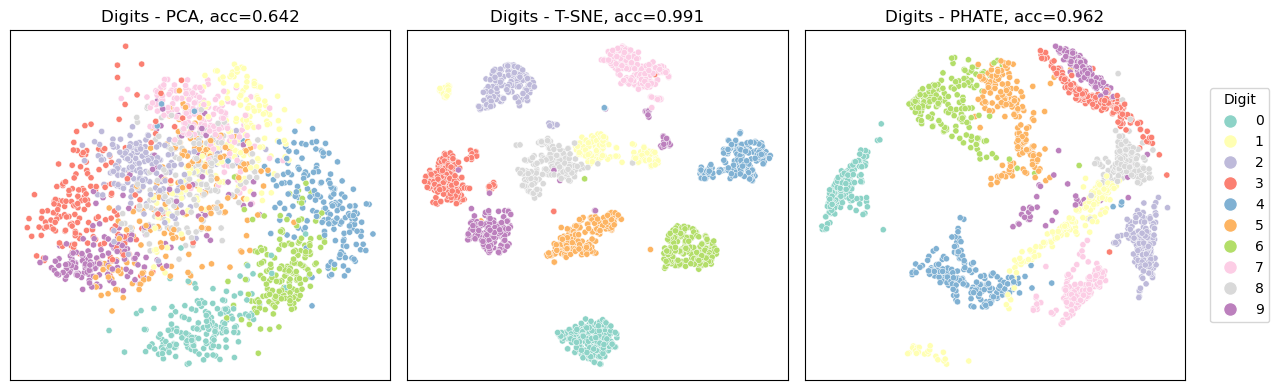

In [212]:
# run a classifier over these embeddings
digit_labels = [int(d) for d in digit_labels]
accuracies = []
confusion_mtx = []
for d in [digits_pca, digits_tsne, digits_phate]:
    # Not doing any real robust cross-valudation here - just splitting the data once, using 1/4 the samples as test
    X_train, X_test, y_train, y_test = train_test_split(d, digit_labels, test_size=0.25, random_state=0)
    mod = SVC(kernel='rbf',C=10).fit(X_train,y_train)
    acc = mod.score(X_test,y_test)
    accuracies.append(acc)
    pred = mod.predict(X_test)
    confusion_mtx.append([y_test, pred])

# now let's set up some plots
# Create figure with GridSpec
fig = plt.figure(figsize=(13, 4))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.2])  # 3 scatterplots + 1 legend

uniq_labels = np.unique(digit_labels)
palette=sns.color_palette('Set3', len(uniq_labels))
color_dict = {int(group): color for group, color in zip(uniq_labels, palette)}

# Create axes for each matrix and colorbar
axes = [plt.subplot(gs[i]) for i in range(4)]

temp = pd.DataFrame({'x':digits_pca[:,0], 'y':digits_pca[:,1], 'c':digit_labels})
g=sns.scatterplot(data=temp, x="x", y="y", hue="c", palette=color_dict, ax=axes[0],s=20,  legend=False)
g.set(xticks=[],yticks=[],xlabel='',ylabel='',title=f'Digits - PCA, acc={np.round(accuracies[0],3)}')

temp = pd.DataFrame({'x':digits_tsne[:,0], 'y':digits_tsne[:,1], 'c':digit_labels})
g=sns.scatterplot(data=temp, x="x", y="y", hue="c",  ax=axes[1], s=20, palette=color_dict, legend=False)
g.set(xticks=[],yticks=[],xlabel='',ylabel='',title=f'Digits - T-SNE, acc={np.round(accuracies[1],3)}')

temp = pd.DataFrame({'x':digits_phate[:,0], 'y':digits_phate[:,1], 'c':digit_labels})
g=sns.scatterplot(data=temp, x="x", y="y", hue="c",  ax=axes[2], s=20, palette=color_dict, legend=False)
g.set(xticks=[],yticks=[],xlabel='',ylabel='',title=f'Digits - PHATE, acc={np.round(accuracies[2],3)}')

axes[3].axis('off')

# Create custom legend handles
legend_handles = []
for group, color in color_dict.items():
    handle = Line2D(
        [0], [0], 
        marker='o', 
        color='w',
        markerfacecolor=color, 
        markersize=10, 
        label=group
    )
    legend_handles.append(handle)

# Add the legend to the separate axis with adjusted parameters for many groups
legend = axes[3].legend(
    handles=legend_handles, 
    loc='center', 
    fontsize=10 if len(uniq_labels) > 6 else 12,  # Smaller font for many groups
    frameon=True, 
    title='Digit',
    ncol=1 if len(uniq_labels) <= 8 else 1  # Use 2 columns if more than 8 groups
)

fig.tight_layout()

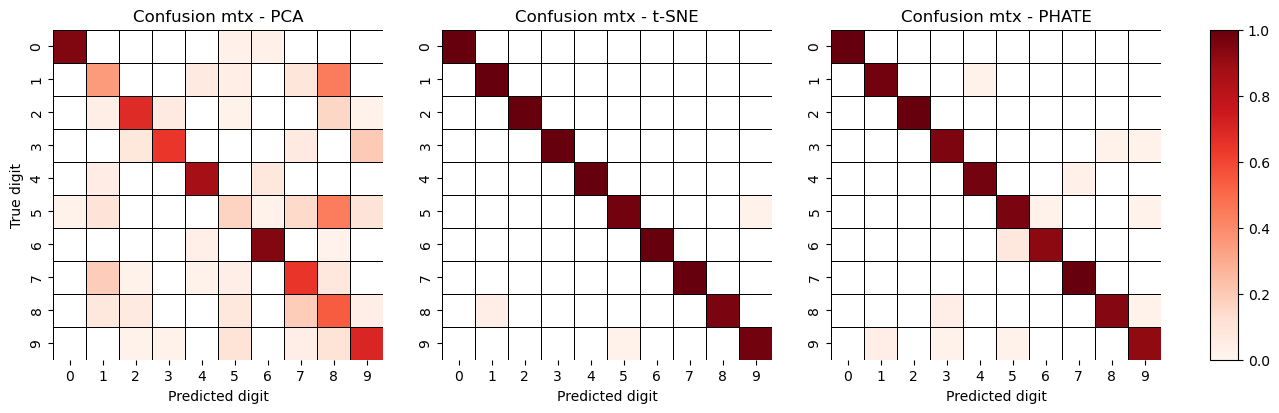

In [213]:
# Let's also look at the mistakes made by each method -- can we see any structure? 
cmat_pca = confusion_matrix(confusion_mtx[0][0], confusion_mtx[0][1], normalize='true')
cmat_tsne = confusion_matrix(confusion_mtx[1][0], confusion_mtx[1][1], normalize='true')
cmat_phate = confusion_matrix(confusion_mtx[2][0], confusion_mtx[2][1], normalize='true')

# Create figure with GridSpec
fig = plt.figure(figsize=(13, 4))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.08])  # 3 matrices + 1 narrow colorbar

# Create axes for each matrix and colorbar
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
cbar_ax = plt.subplot(gs[3])  # Separate axis for colorbar

# Plot heatmaps without colorbars
g1 = sns.heatmap(cmat_pca, ax=ax1, square=True, cbar=False, vmin=0, vmax=1, 
               cmap='Reds', linewidths=0.5, linecolor='k',mask=cmat_pca==0)
g2 = sns.heatmap(cmat_tsne, ax=ax2, square=True, cbar=False, vmin=0, vmax=1, 
               cmap='Reds', linewidths=0.5, linecolor='k',mask=cmat_tsne==0)
g3 = sns.heatmap(cmat_phate, ax=ax3, square=True, cbar=False, vmin=0, vmax=1, 
               cmap='Reds', linewidths=0.5, linecolor='k',mask=cmat_phate==0)

# Add a separate colorbar
cbar = fig.colorbar(g3.collections[0], cax=cbar_ax)

# Set titles and labels
ax1.set_title('Confusion mtx - PCA')
ax1.set_ylabel('True digit')
ax1.set_xlabel('Predicted digit')

ax2.set_title('Confusion mtx - t-SNE')
ax2.set_ylabel('')
ax2.set_xlabel('Predicted digit')

ax3.set_title('Confusion mtx - PHATE')
ax3.set_ylabel('')
ax3.set_xlabel('Predicted digit')

plt.tight_layout()
plt.show()

In this confusion matrix, we can see which pairs of digits are most commonly confused within each embedding space. The vast majortity of the time, the model predicts the true digit in the t-SNE and PHATE spaces, shown by the diagonal. There are some sparse mistakes in the PHATE and t-SNE matrices, whereas there are more patterned ones in the PCA space -- confusing digits that are pretty visually similar, like 5 and 8 or 7 and 1. 

## Dataset 3: Micro-mass
This is a dataset from OpenML.org ([link](https://www.openml.org/d/1514)): identification of microorganisms from mass-spectrometry data. For our purposes, this is an example of a high dimesional dataset where there are far more features than samples, more similar to what we'd see in fMRI data, and the data come from 10 microorganisms, resulting in a 10-way classification problem. We can fetch these data using the scikit-learn [function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml).

In [284]:
micromass_data, micromass_labels = datasets.fetch_openml(return_X_y=True, data_id=1514)
micromass_X, micromass_y = micromass_data.values, [int(i) for i in micromass_labels.values]
micromass_X = np.nan_to_num(scipy.stats.zscore(micromass_X, axis=1))
print(micromass_X.shape, np.unique(micromass_y, return_counts=True))

# embed with PCA, T-SNE, and PHATE 
X_pca = PCA(n_components=2).fit_transform(micromass_X)
X_tsne = TSNE(n_components=2,verbose=0, random_state=0).fit_transform(micromass_X)
X_phate = phate.PHATE(n_components=2, verbose=0, knn=20, gamma=-1, t=20).fit_transform(micromass_X)

(360, 1300) (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36]))


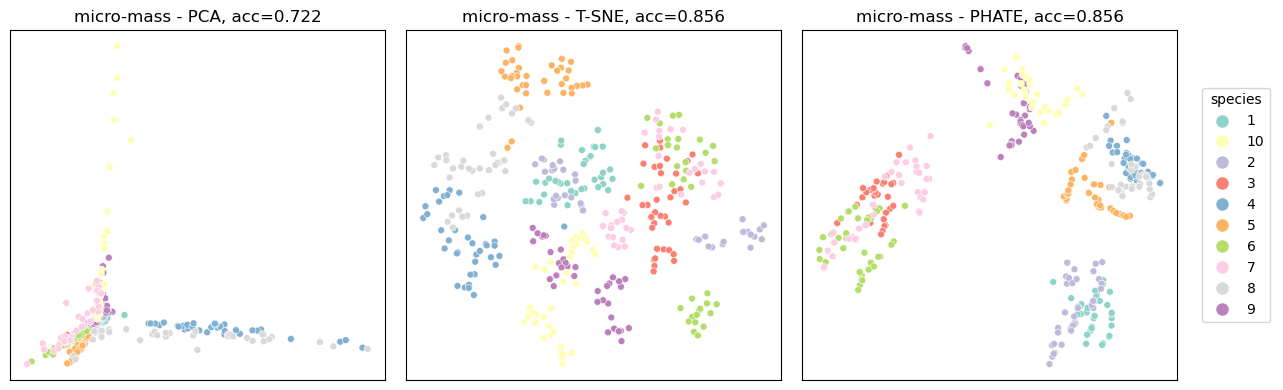

In [288]:
# run a classifier over these embeddings
accuracies = []
confusion_mtx = []

for d in [X_pca, X_tsne, X_phate]:
    X_train, X_test, y_train, y_test = train_test_split(d, micromass_y, test_size=0.25, random_state=0)
    mod = SVC(kernel='rbf', C=10).fit(X_train, y_train)
    acc = mod.score(X_test,y_test)
    accuracies.append(acc)
    pred = mod.predict(X_test)
    confusion_mtx.append([y_test, pred])

# now let's set up some plots
# Create figure with GridSpec
fig = plt.figure(figsize=(13, 4))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.2])  # 3 matrices + 1 narrow colorbar

uniq_labels = np.unique(y)
palette=sns.color_palette('Set3',len(uniq_labels))
color_dict = {group: color for group, color in zip(uniq_labels, palette)}

# Create axes for each matrix and colorbar
axes = [plt.subplot(gs[i]) for i in range(4)]

temp = pd.DataFrame({'x':dia_pca[:,0], 'y':dia_pca[:,1], 'c':y})
g=sns.scatterplot(data=temp, x="x", y="y", hue="c", palette=color_dict, ax=axes[0],s=25,  legend=False)
g.set(xticks=[],yticks=[],xlabel='',ylabel='',title=f'micro-mass - PCA, acc={np.round(accuracies[0],3)}')

temp = pd.DataFrame({'x':dia_tsne[:,0], 'y':dia_tsne[:,1], 'c':y})
g=sns.scatterplot(data=temp, x="x", y="y", hue="c",  ax=axes[1], s=25, palette=color_dict, legend=False)
g.set(xticks=[],yticks=[],xlabel='',ylabel='',title=f'micro-mass - T-SNE, acc={np.round(accuracies[1],3)}')

temp = pd.DataFrame({'x':dia_phate[:,0], 'y':dia_phate[:,1], 'c':y})
g=sns.scatterplot(data=temp, x="x", y="y", hue="c",  ax=axes[2], s=25, palette=color_dict, legend=False)
g.set(xticks=[],yticks=[],xlabel='',ylabel='',title=f'micro-mass - PHATE, acc={np.round(accuracies[2],3)}')

axes[3].axis('off')


# Create custom legend handles
legend_handles = []
for group, color in color_dict.items():
    handle = Line2D(
        [0], [0], 
        marker='o', 
        color='w',
        markerfacecolor=color, 
        markersize=10, 
        label=group
    )
    legend_handles.append(handle)

# Add the legend to the separate axis with adjusted parameters for many groups
legend = axes[3].legend(
    handles=legend_handles, 
    loc='center', 
    fontsize=10 ,
    frameon=True, 
    title='species',
    ncol=1 
)


fig.tight_layout()

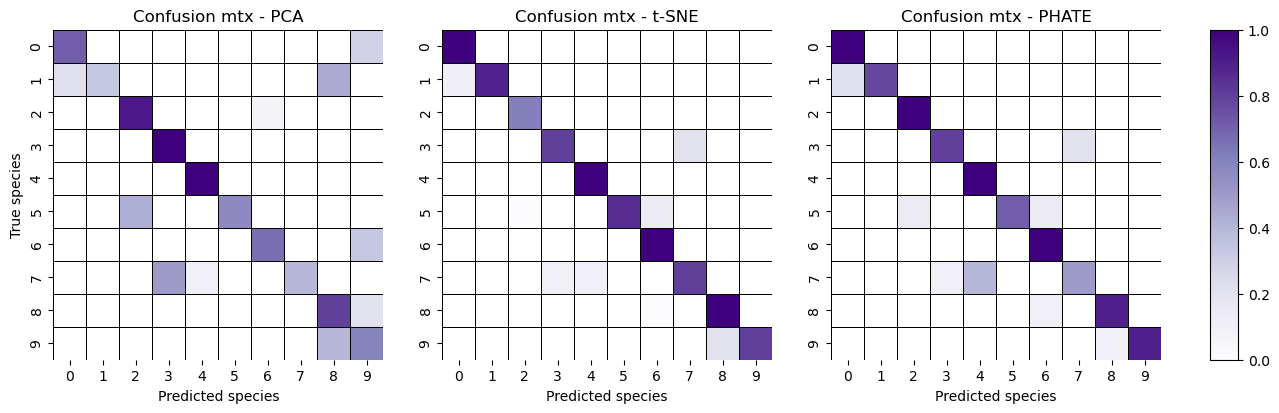

In [287]:
# Let's also look at the mistakes made by each method -- can we see any structure? 
cmat_pca = confusion_matrix(confusion_mtx[0][0], confusion_mtx[0][1],normalize='true')
cmat_tsne = confusion_matrix(confusion_mtx[1][0], confusion_mtx[1][1],normalize='true')
cmat_phate = confusion_matrix(confusion_mtx[2][0], confusion_mtx[2][1],normalize='true')

# Create figure with GridSpec
fig = plt.figure(figsize=(13, 4))
gs = GridSpec(1, 4, width_ratios=[1, 1, 1, 0.08])  # 3 matrices + 1 narrow colorbar

# Create axes for each matrix and colorbar
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
cbar_ax = plt.subplot(gs[3])  # Separate axis for colorbar
maxx=1

# Plot heatmaps without colorbars
g1 = sns.heatmap(cmat_pca, ax=ax1, square=True, cbar=False, vmin=0, vmax=maxx, 
               cmap='Purples', linewidths=0.5, linecolor='k',mask=cmat_pca==0)
g2 = sns.heatmap(cmat_tsne, ax=ax2, square=True, cbar=False, vmin=0, vmax=maxx, 
               cmap='Purples', linewidths=0.5, linecolor='k',mask=cmat_phate==0)
g3 = sns.heatmap(cmat_phate, ax=ax3, square=True, cbar=False, vmin=0, vmax=maxx, 
               cmap='Purples', linewidths=0.5, linecolor='k',mask=cmat_phate==0)

# Add a separate colorbar
cbar = fig.colorbar(g3.collections[0], cax=cbar_ax)

# Set titles and labels
ax1.set_title('Confusion mtx - PCA')
ax1.set_ylabel('True species')
ax1.set_xlabel('Predicted species')

ax2.set_title('Confusion mtx - t-SNE')
ax2.set_ylabel('')
ax2.set_xlabel('Predicted species')

ax3.set_title('Confusion mtx - PHATE')
ax3.set_ylabel('')
ax3.set_xlabel('Predicted species')

plt.tight_layout()
plt.show()


Once again, what we're seeing is that the nonlinear methods provide better embedding spaces for predicting the different microorganism species classes -- around a 14\% improvement over the PCA space. 

# Manifold learning on simulated fMRI datasets 
Now, we're going to work with some simulated fMRI data, generated to resemble the noise properties of data used in our recent [paper](https://modlab.yale.edu/sites/default/files/files/Buschetal2024.pdf). This is to highlight the benefit of nonlinear, multi-view manifold learning. The X-values are simulated brain activations, one per voxel in a region of interest, for those same 400 participants, so a matrix of shape (400, 100). The y-values are simulated scores for those participants, and the E-values are simulated scores for those same 400 participants on several external features that we think would inform the relationship between X and y. 

In [289]:
loaded_data = load_simulated_data_manifold_example()

# X values are simulated brain data for 400 participants, where each participant has 100 features 
X_values = loaded_data['input_data']

# y values are simulated scores on an external metric (e.g., scores on a mental health metric)
y_values = loaded_data['scores']

# E values are simulated scores on a variety of external features that we think moderate the brain-behavior relationship
E_values = loaded_data['exogenous_data']
print(X_values.shape, y_values.shape, E_values.shape)

(400, 100) (400,) (6, 400)


In [290]:
# These values should already be z-scored; if not, check
for V in [X_values, y_values, E_values]:
    print(f'mean close to 0? {np.allclose(np.mean(V,axis=0), 0)}, std close to 1? {np.allclose(np.mean(np.std(V,axis=0)), 1)}')

mean close to 0? True, std close to 1? True
mean close to 0? True, std close to 1? True
mean close to 0? True, std close to 1? True


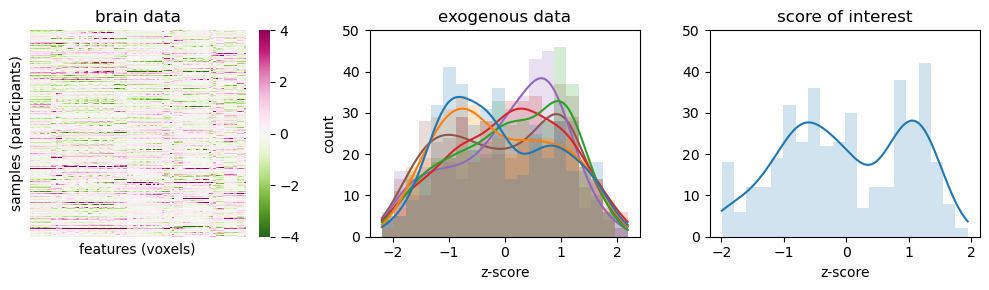

In [292]:
# Plot the brain, environment, and score to predict
# These show the range of activation values, as well as the distribution of variables and the score to predict.
fig,ax=plt.subplots(1,3,figsize=(10,3))
g=sns.heatmap(X_values, ax=ax[0], vmin=-4, vmax=4, cmap='PiYG_r')
g.set(xticks=[],yticks=[],xlabel='features (voxels)', ylabel='samples (participants)', title='brain data')
g=sns.histplot(E_values.T, ax=ax[1], kde=True, bins=20, legend=False, alpha=0.2, linewidth=0)
g.set(xlabel='z-score', ylabel='count',  title='exogenous data', ylim=[0,50])
g=sns.histplot(y_values, ax=ax[2], kde=True, bins=20, legend=False, alpha=0.2, linewidth=0)
g.set(xlabel='z-score', ylabel='',  title='score of interest', ylim=[0,50])
fig.tight_layout()


These show the range of activation values, as well as the distribution of variables and the score to predict.


## Dimensionality reduction & manifold learning
As we saw before, there are many different approaches to dimensionality reduction. Here, we're going to look at some of the most common approaches and see if the projected spaces represent variance along the scores we're trying to predict.  

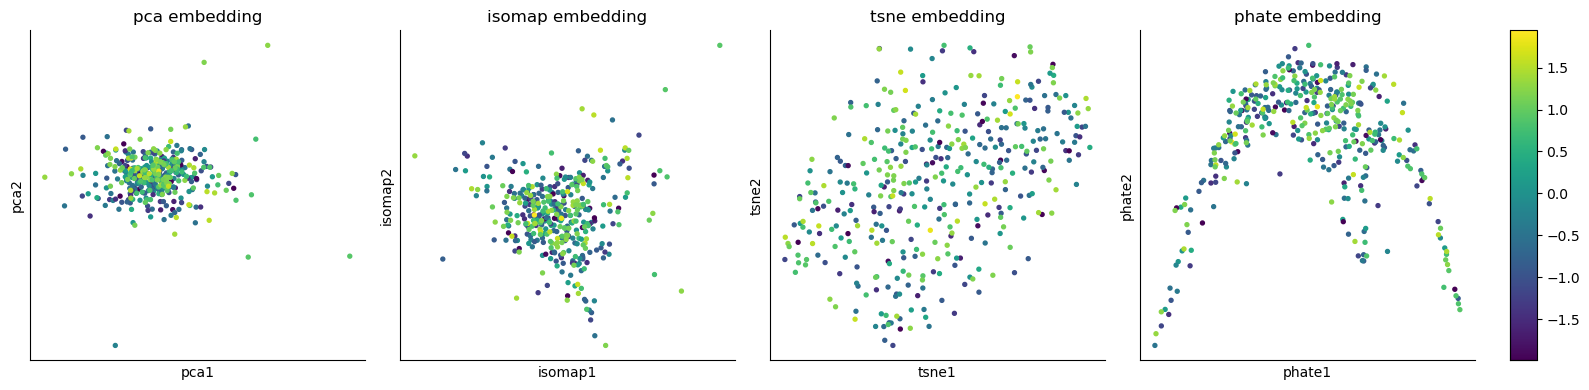

In [297]:
# Reduce dimensionality using PCA, Isomap, T-SNE, PHATE - 2 dimensions for visualization
n_components = 2

pca_embedding = PCA(n_components=n_components).fit_transform(X_values)
iso_embedding = Isomap(n_components=n_components).fit_transform(X_values)
tsne_embedding = TSNE(n_components=n_components, random_state=0).fit_transform(X_values)
phate_embedding = phate.PHATE(n_components=n_components,verbose=0).fit_transform(X_values)
embeddings = [pca_embedding, iso_embedding, tsne_embedding, phate_embedding]
titles = ['pca','isomap','tsne','phate']
# Create figure with GridSpec
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.08])  # 3 matrices + 1 narrow colorbar

# Create axes for each matrix and colorbar
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

cbar_ax = plt.subplot(gs[4])  # Separate axis for colorbar
for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.scatter(embeddings[i][:,0], y=embeddings[i][:,1], s=8, c=y_values)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{titles[i]} embedding')
    ax.set_xlabel(f'{titles[i]}1')
    ax.set_ylabel(f'{titles[i]}2')
    
# Add a separate colorbar
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax)

fig.tight_layout()
sns.despine()

Unlike with the toy datasets, we see here that these embedding techniques don't show any sort of clustering related to this variable. But what if we include the external variables? Does including this information help?

(400, 100) (400, 6) None


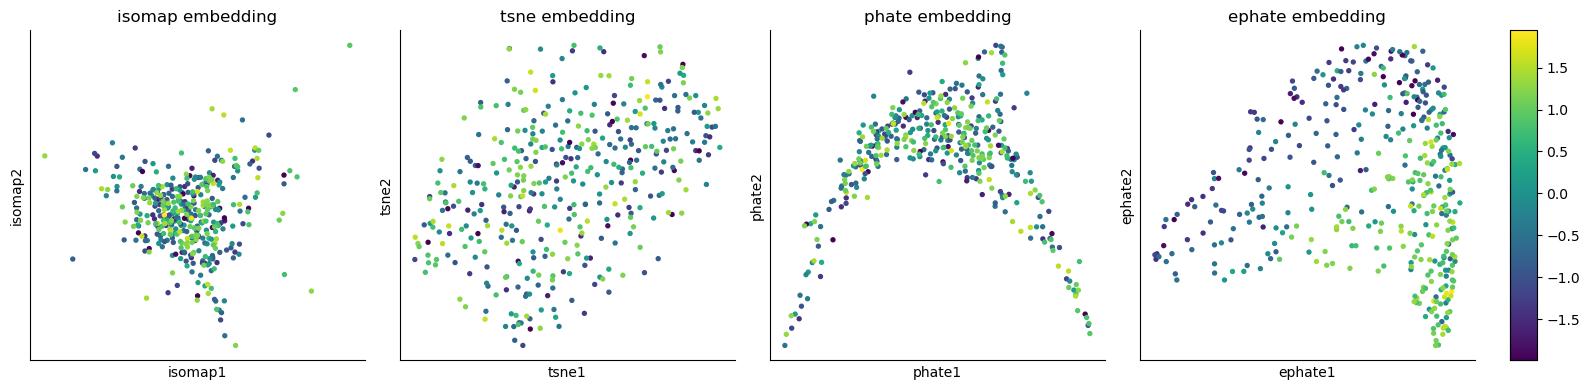

In [298]:
# Reduce dimensionality using PCA, PHATE, UMAP, and E-PHATE - 2 dimensions for visualization
n_components = 2
iso_embedding = Isomap(n_components=n_components).fit_transform(X_values)
tsne_embedding = TSNE(n_components=n_components, random_state=0).fit_transform(X_values)
phate_embedding = phate.PHATE(n_components=n_components,verbose=0).fit_transform(X_values)
ephate_embedding = ephate.EPHATE(n_components=n_components,X2_metric='euclidean', verbose=0).fit_transform(X_values, E_values.T)

embeddings = [iso_embedding, tsne_embedding, phate_embedding, ephate_embedding]
titles = ['isomap','tsne','phate','ephate']
# Create figure with GridSpec
fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.08])  # 3 matrices + 1 narrow colorbar

# Create axes for each matrix and colorbar
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])

cbar_ax = plt.subplot(gs[4])  # Separate axis for colorbar
for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    ax.scatter(embeddings[i][:,0], y=embeddings[i][:,1], s=8, c=y_values)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{titles[i]} embedding')
    ax.set_xlabel(f'{titles[i]}1')
    ax.set_ylabel(f'{titles[i]}2')
    
# Add a separate colorbar
cbar = fig.colorbar(ax.collections[0], cax=cbar_ax)

fig.tight_layout()
sns.despine()

The EPHATE embedding shows some nice clustering based on participant's scores, showing that the dimensions learned capture variance related to this variable of interest. 

# Quantifying embedding structure
We can quantify how well the embedding reflects a variable of interest by training regression models on one portion of the samples and testing the regression model on another portion of samples (cross-validation). Here, we're using nested KFold cross-validation to select 1) the parameters of a ridge regression model and 2) the number of embedding dimensions that best predict the variable of interest for each embedding type.

In [299]:
# Use embeddings to run prediction
inner_cv = KFold(n_splits=2)
outer_cv = KFold(n_splits=5)

results_df = pd.DataFrame(columns=['dimensions','r2','spearmanr','best_alpha','name','fold'])
dim2test = [2,3,4,5,6,7,8,10,20]
alphas = 10**np.linspace(-4, 10, 15)
for n in dim2test:
    # fit ephate
    pca_embedding = PCA(n_components=n).fit_transform(X_values)
    try:
        tsne_embedding = TSNE(n_components=n).fit_transform(X_values)
    except:
        print('')
    phate_embedding = phate.PHATE(n_components=n,verbose=0).fit_transform(X_values)
    ephate_embedding = ephate.EPHATE(n_components=n,X2_metric='euclidean', verbose=0).fit_transform(X_values, E_values.T)
    embeddings = {'pca':pca_embedding, 'tsne': tsne_embedding, 'phate': phate_embedding, 'ephate': ephate_embedding}
    for name, data in embeddings.items():
        lr_cv = RidgeCV(alphas=alphas,  fit_intercept=True, cv=inner_cv)
        lr_cv.fit(data, y_values)
        best_alpha = lr_cv.alpha_
        # fit a new ridge
        fold=0
        for train_idx,test_idx in outer_cv.split(np.arange(data.shape[0])):
            lr = Ridge(alpha=best_alpha)
            lr.fit(data[train_idx], y_values[train_idx])
            ypred = lr.predict(data[test_idx])
            rsq = r2_score(y_values[test_idx], ypred)
            r = scipy.stats.spearmanr(ypred, y_values[test_idx])[0]
            results_df.loc[len(results_df)] = {'dimensions':n, 'r2':rsq, 'spearmanr':r, 'best_alpha':best_alpha,'fold':fold, 'name':name}
            fold+=1
            
names = ['mean','voxels']
for i, data in enumerate([X_values.mean(axis=1).reshape(-1,1), X_values]):
    name = names[i]
    # identify the best alpha value
    lr_cv = RidgeCV(alphas=alphas,  fit_intercept=True, cv=inner_cv)
    lr_cv.fit(data, y_values)
    fold=0
    for train_idx, test_idx in outer_cv.split(np.arange(data.shape[0])):
        lr = Ridge(alpha=best_alpha)
        lr.fit(data[train_idx], y_values[train_idx])
        ypred = lr.predict(data[test_idx])
        rsq = r2_score(y_values[test_idx], ypred)
        r = scipy.stats.spearmanr(ypred, y_values[test_idx])[0]
        results_df.loc[len(results_df)] = {'dimensions':name, 'r2':rsq, 'spearmanr':r, 'best_alpha':best_alpha,'fold':fold, 'name':name}
        fold+=1


(400, 100) (400, 6) None
(400, 100) (400, 6) None

(400, 100) (400, 6) None

(400, 100) (400, 6) None

(400, 100) (400, 6) None

(400, 100) (400, 6) None

(400, 100) (400, 6) None

(400, 100) (400, 6) None

(400, 100) (400, 6) None


<Axes: xlabel='dimensions', ylabel='spearmanr'>

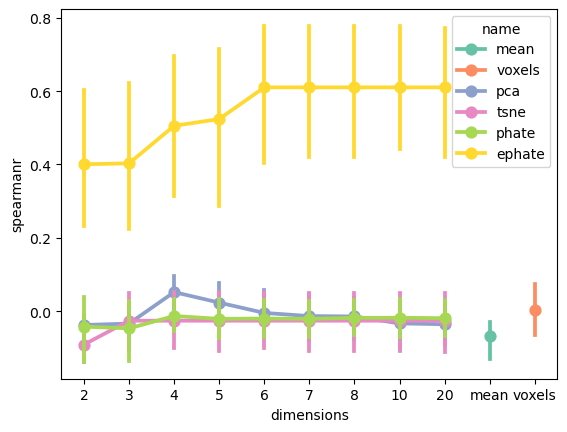

In [301]:
sns.pointplot(data=results_df, x='dimensions', y='spearmanr', hue='name',
              hue_order=['mean','voxels','pca','tsne','phate','ephate'],
             palette='Set2')


What we see here is that E-PHATE embeddings are vastly more accurate than the other methods, but it really doesn't matter how many dimensions we retain. Let's select a random number of dimensions (4) and run the analysis again 

In [302]:
# Now, let's select one embedding dimensionality (4) and rerun the prediction: 
k = 4
inner_cv = KFold(n_splits=10)
alphas = 10**np.linspace(-4, 10, 20)
pca_embedding = PCA(n_components=k).fit_transform(X_values)
tsne_embedding = TSNE(n_components=3).fit_transform(X_values) # 
iso_embedding = Isomap(n_components=k).fit_transform(X_values)
phate_embedding = phate.PHATE(n_components=k,verbose=0).fit_transform(X_values)
ephate_embedding = ephate.EPHATE(n_components=k, X2_metric='euclidean', verbose=0).fit_transform(X_values, E_values.T)
xmean = X_values.mean(axis=1).reshape(-1,1) 
embeddings = {'pca':pca_embedding, 'tsne': tsne_embedding, 'phate': phate_embedding, 'ephate': ephate_embedding, 'isomap':iso_embedding, 'mean':xmean, 'voxels':X_values}

(400, 100) (400, 6) None


In [303]:
predictions = {}
results_df = pd.DataFrame(columns=['spearmanr','name','fold'])
outer_cv = KFold(n_splits=10)

for name, data in embeddings.items():
    # optimize the number of  
    rr_cv = RidgeCV(alphas=alphas, cv=inner_cv)
    rr_cv.fit(data, y_values)
    best_alpha = rr_cv.alpha_
    # now set a new model
    predictions[name] = np.zeros(len(y_values))
    for i,(train,test) in enumerate(outer_cv.split(np.arange(len(y_values)))):
        rr = Ridge(alpha=best_alpha)
        rr.fit(data[train], y_values[train])
        predicted = rr.predict(data[test])
        predictions[name][test]=predicted
        corr = scipy.stats.spearmanr(y_values[test], predicted)[0]        
        results_df.loc[len(results_df)] = {'spearmanr':corr, 'fold':i, 'name':name}    

<Axes: xlabel='name', ylabel='spearmanr'>

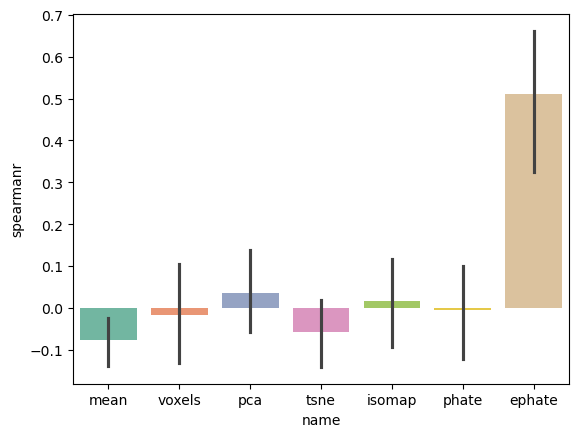

In [304]:
sns.barplot(x='name', y='spearmanr', data=results_df, hue='name', 
            hue_order=['mean','voxels','pca','tsne','isomap','phate','ephate'], 
            order=['mean','voxels','pca','tsne','isomap','phate','ephate'],palette='Set2')

So this is an example of an instance where a mulit-view manifold affords better prediction of the target variable than any of the brain embeddings alone! If you want to read more about these methods, you can look at our [paper](https://modlab.yale.edu/sites/default/files/files/Buschetal2024.pdf) and [python package](https://pypi.org/project/EPHATE/).